In [ ]:
# After installations if the tf version is inconsistent the runtime might crash
# If that happens, uncomment the `os.kill` line and run this cell again to restart the runtime, then proceed from the next cell.
# import os
# os.kill(os.getpid(), 9)

# !pip install -q --upgrade --force-reinstall \
#     tensorflow==2.12.1 \
#     tensorflow-hub==0.13.0 \
#     tensorflow-text==2.12.1


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from tensorflow.keras import layers

# Check tf version
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.12.1


In [ ]:
df = pd.read_csv('/content/TAB_binaryLabel.csv')
df.columns = ['text','label']
assert {'text','label'}.issubset(df.columns), "CSV must have 'text' and 'label' columns"
print("CSV file loaded successfully.")
print(df.head())

CSV file loaded successfully.
                                                text  label
0  Timber-Yielding Plants of the Tamaulipan Thorn...      1
1  Restoration: Success and Completion Criteria R...      1
2  Soil Carbon Sequestration: Ethiopia Sequestrat...      1
3  Village Bamboos It has been recognized that ba...      1
4  Physical protection by soil aggregates stabili...      1


In [ ]:
train_df, tmp_df = train_test_split(
    df, test_size=0.20, random_state=42, stratify=df['label']
)
val_df, test_df = train_test_split(
    tmp_df, test_size=0.50, random_state=42, stratify=tmp_df['label']
)
print(f"\nDataset splits: Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")



Dataset splits: Train: 6180, Val: 772, Test: 773


In [ ]:
class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = {i : class_weights_array[i] for i in range(len(class_weights_array))}
print("\nCalculated Class Weights to counter imbalance:")
print(class_weights)


Calculated Class Weights to counter imbalance:
{0: 0.553069625917308, 1: 5.21079258010118}


In [ ]:
param_grid = { # we can change too but these are just prelim stuff
    'learning_rate': [5e-5, 3e-5, 2e-5, 1e-5],
    'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'batch_size': [16, 32]
}
grid = list(ParameterGrid(param_grid))
random.shuffle(grid)
print(f"\n{len(grid)} total hyperparameter combinations created for the search.")


40 total hyperparameter combinations created for the search.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def df_to_dataset(dataframe, batch_size=32, shuffle=True):
    """Converts a pandas DataFrame to a tf.data.Dataset."""
    ds = tf.data.Dataset.from_tensor_slices(
        (dataframe['text'].values, dataframe['label'].values)
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    return ds.batch(batch_size).prefetch(AUTOTUNE)

# small bert has 4 encoded layers
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2"

preprocess_model = hub.KerasLayer(preprocess_url, name='preprocessing')
encoder_model = hub.KerasLayer(encoder_url, trainable=True, name='BERT_encoder')

def build_model(learning_rate, dropout_rate):
    """Builds and compiles a new BERT model."""
    text_input = layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = preprocess_model(text_input)
    outputs = encoder_model(encoder_inputs)
    pooled_output = outputs['pooled_output']
    x = layers.Dropout(dropout_rate)(pooled_output)
    logits  = layers.Dense(1, activation='sigmoid', name='classifier')(x)

    model = tf.keras.Model(inputs=text_input, outputs=logits)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
        ]
    )
    return model


In [ ]:
results = []
best_val_precision = -1
best_params = None
best_model_path = None

MIN_RECALL_THRESHOLD_SWEEP = 0.7 # I think we still want a somewhat solid recal
num_searches = 10 # can adjust if the runtime gets better
print(f"\nStarting hyperparameter sweep. Testing {min(num_searches, len(grid))} random combinations...")
print(f"Maximize Precision while keeping Recall >= {MIN_RECALL_THRESHOLD_SWEEP}")

for i, params in enumerate(grid[:num_searches]):
    print("\n" + "="*50)
    print(f"RUN {i+1}/{min(num_searches, len(grid))}")
    print(f"PARAMS: {params}")
    print("="*50)

    train_ds = df_to_dataset(train_df, batch_size=params['batch_size'], shuffle=True)
    val_ds   = df_to_dataset(val_df, batch_size=params['batch_size'], shuffle=False)
    model = build_model(learning_rate=params['learning_rate'], dropout_rate=params['dropout_rate'])
    model_path = f"checkpoint_model_run_{i}"
    # early stopping and checkpoints to save runtime
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path,
        monitor='val_recall',
        mode='max',
        save_best_only=True,
        verbose=0
    )
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_recall',
        mode='max',
        patience=1, # right now waiting 2 epochs hasn't helped so decreased to 1
        verbose=1,
        restore_best_weights=True
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[early_stop, checkpoint_cb],
        class_weight=class_weights,
        verbose=1
    )

    val_loss, val_acc, val_precision, val_recall = model.evaluate(val_ds, verbose=0)
    print(f"Validation Metrics for this run: Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

    results.append({
        'run': i+1,
        'val_recall': val_recall,
        'val_precision': val_precision,
        'params': params,
    })

    # check if recall passes mark and if precision is highest so far
    if val_recall >= MIN_RECALL_THRESHOLD_SWEEP and val_precision > best_val_precision:
        best_val_precision = val_precision
        best_params = params
        best_model_path = model_path
        print(f"New best model: Val Precision: {val_precision:.4f} (Recall: {val_recall:.4f})")





Starting hyperparameter sweep. Testing 10 random combinations...
Maximize Precision while keeping Recall >= 0.7

RUN 1/10
PARAMS: {'batch_size': 16, 'dropout_rate': 0.4, 'learning_rate': 3e-05}
Epoch 1/10
387/387 [==============================] - ETA: 0s - loss: 0.7015 - accuracy: 0.5895 - precision: 0.1343 - recall: 0.6020

387/387 [==============================] - 238s 591ms/step - loss: 0.7015 - accuracy: 0.5895 - precision: 0.1343 - recall: 0.6020 - val_loss: 0.5562 - val_accuracy: 0.7047 - val_precision: 0.2105 - val_recall: 0.7568
Epoch 2/10
387/387 [==============================] - ETA: 0s - loss: 0.5635 - accuracy: 0.7167 - precision: 0.2139 - recall: 0.7302

387/387 [==============================] - 226s 584ms/step - loss: 0.5635 - accuracy: 0.7167 - precision: 0.2139 - recall: 0.7302 - val_loss: 1.0404 - val_accuracy: 0.4611 - val_precision: 0.1481 - val_recall: 0.9730
Epoch 3/10
387/387 [==============================] - 219s 566ms/step - loss: 0.4390 - accuracy: 0.7764 - precision: 0.2785 - recall: 0.8364 - val_loss: 0.4712 - val_accuracy: 0.7578 - val_precision: 0.2420 - val_recall: 0.7162
Epoch 3: early stopping
Validation Metrics for this run: Precision: 0.1481, Recall: 0.9730
New best model: Val Precision: 0.1481 (Recall: 0.9730)

RUN 2/10
PARAMS: {'batch_size': 32, 'dropout_rate': 0.5, 'learning_rate': 5e-05}
Epoch 1/10
194/194 [==============================] - ETA: 0s - loss: 0.5161 - accuracy: 0.7497 - precision: 0.2435 - recall: 0.7639

194/194 [==============================] - 214s 1s/step - loss: 0.5161 - accuracy: 0.7497 - precision: 0.2435 - recall: 0.7639 - val_loss: 0.6580 - val_accuracy: 0.6710 - val_precision: 0.2020 - val_recall: 0.8243
Epoch 2/10
194/194 [==============================] - 202s 1s/step - loss: 0.3815 - accuracy: 0.8168 - precision: 0.3291 - recall: 0.8752 - val_loss: 0.5876 - val_accuracy: 0.7215 - val_precision: 0.2257 - val_recall: 0.7838
Epoch 2: early stopping
Validation Metrics for this run: Precision: 0.2020, Recall: 0.8243
New best model: Val Precision: 0.2020 (Recall: 0.8243)

RUN 3/10
PARAMS: {'batch_size': 32, 'dropout_rate': 0.5, 'learning_rate': 2e-05}
Epoch 1/10
194/194 [==============================] - ETA: 0s - loss: 0.3839 - accuracy: 0.8215 - precision: 0.3329 - recall: 0.8567

194/194 [==============================] - 215s 1s/step - loss: 0.3839 - accuracy: 0.8215 - precision: 0.3329 - recall: 0.8567 - val_loss: 0.4044 - val_accuracy: 0.8277 - val_precision: 0.2908 - val_recall: 0.5541
Epoch 2/10
194/194 [==============================] - 201s 1s/step - loss: 0.2639 - accuracy: 0.8772 - precision: 0.4351 - recall: 0.9376 - val_loss: 0.4270 - val_accuracy: 0.8653 - val_precision: 0.3529 - val_recall: 0.4865
Epoch 2: early stopping
Validation Metrics for this run: Precision: 0.2908, Recall: 0.5541

RUN 4/10
PARAMS: {'batch_size': 32, 'dropout_rate': 0.4, 'learning_rate': 2e-05}
Epoch 1/10
194/194 [==============================] - ETA: 0s - loss: 0.2975 - accuracy: 0.8570 - precision: 0.3943 - recall: 0.9157

194/194 [==============================] - 215s 1s/step - loss: 0.2975 - accuracy: 0.8570 - precision: 0.3943 - recall: 0.9157 - val_loss: 0.4412 - val_accuracy: 0.8251 - val_precision: 0.2953 - val_recall: 0.5946
Epoch 2/10
194/194 [==============================] - 201s 1s/step - loss: 0.2096 - accuracy: 0.9045 - precision: 0.5013 - recall: 0.9562 - val_loss: 0.4472 - val_accuracy: 0.8407 - val_precision: 0.3040 - val_recall: 0.5135
Epoch 2: early stopping
Validation Metrics for this run: Precision: 0.2953, Recall: 0.5946

RUN 5/10
PARAMS: {'batch_size': 32, 'dropout_rate': 0.4, 'learning_rate': 1e-05}
Epoch 1/10
194/194 [==============================] - ETA: 0s - loss: 0.2350 - accuracy: 0.8875 - precision: 0.4589 - recall: 0.9595

194/194 [==============================] - 214s 1s/step - loss: 0.2350 - accuracy: 0.8875 - precision: 0.4589 - recall: 0.9595 - val_loss: 0.4251 - val_accuracy: 0.8614 - val_precision: 0.3540 - val_recall: 0.5405
Epoch 2/10
194/194 [==============================] - 202s 1s/step - loss: 0.1593 - accuracy: 0.9280 - precision: 0.5740 - recall: 0.9680 - val_loss: 0.4426 - val_accuracy: 0.8744 - val_precision: 0.3763 - val_recall: 0.4730
Epoch 2: early stopping
Validation Metrics for this run: Precision: 0.3540, Recall: 0.5405

RUN 6/10
PARAMS: {'batch_size': 32, 'dropout_rate': 0.5, 'learning_rate': 3e-05}
Epoch 1/10
194/194 [==============================] - ETA: 0s - loss: 0.2192 - accuracy: 0.9061 - precision: 0.5058 - recall: 0.9511

194/194 [==============================] - 215s 1s/step - loss: 0.2192 - accuracy: 0.9061 - precision: 0.5058 - recall: 0.9511 - val_loss: 0.4907 - val_accuracy: 0.8446 - val_precision: 0.3231 - val_recall: 0.5676
Epoch 2/10
194/194 [==============================] - 202s 1s/step - loss: 0.2032 - accuracy: 0.9039 - precision: 0.4996 - recall: 0.9477 - val_loss: 0.5366 - val_accuracy: 0.8407 - val_precision: 0.3158 - val_recall: 0.5676
Epoch 2: early stopping
Validation Metrics for this run: Precision: 0.3231, Recall: 0.5676

RUN 7/10
PARAMS: {'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 1e-05}
Epoch 1/10
194/194 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.9346 - precision: 0.5990 - recall: 0.9646

194/194 [==============================] - 214s 1s/step - loss: 0.1637 - accuracy: 0.9346 - precision: 0.5990 - recall: 0.9646 - val_loss: 0.4920 - val_accuracy: 0.8536 - val_precision: 0.3388 - val_recall: 0.5541
Epoch 2/10
194/194 [==============================] - 201s 1s/step - loss: 0.1081 - accuracy: 0.9510 - precision: 0.6655 - recall: 0.9831 - val_loss: 0.4491 - val_accuracy: 0.8847 - val_precision: 0.4000 - val_recall: 0.4054
Epoch 2: early stopping
Validation Metrics for this run: Precision: 0.3388, Recall: 0.5541

RUN 8/10
PARAMS: {'batch_size': 16, 'dropout_rate': 0.3, 'learning_rate': 1e-05}
Epoch 1/10
387/387 [==============================] - ETA: 0s - loss: 0.1352 - accuracy: 0.9432 - precision: 0.6321 - recall: 0.9764

387/387 [==============================] - 231s 580ms/step - loss: 0.1352 - accuracy: 0.9432 - precision: 0.6321 - recall: 0.9764 - val_loss: 0.5133 - val_accuracy: 0.8601 - val_precision: 0.3426 - val_recall: 0.5000
Epoch 2/10
387/387 [==============================] - 218s 564ms/step - loss: 0.0873 - accuracy: 0.9626 - precision: 0.7246 - recall: 0.9848 - val_loss: 0.5086 - val_accuracy: 0.8808 - val_precision: 0.3594 - val_recall: 0.3108
Epoch 2: early stopping
Validation Metrics for this run: Precision: 0.3426, Recall: 0.5000

RUN 9/10
PARAMS: {'batch_size': 16, 'dropout_rate': 0.4, 'learning_rate': 5e-05}
Epoch 1/10
387/387 [==============================] - ETA: 0s - loss: 0.2276 - accuracy: 0.8997 - precision: 0.4882 - recall: 0.9410

387/387 [==============================] - 232s 581ms/step - loss: 0.2276 - accuracy: 0.8997 - precision: 0.4882 - recall: 0.9410 - val_loss: 1.0624 - val_accuracy: 0.7047 - val_precision: 0.2105 - val_recall: 0.7568
Epoch 2/10
387/387 [==============================] - 219s 565ms/step - loss: 0.2027 - accuracy: 0.9092 - precision: 0.5147 - recall: 0.9444 - val_loss: 0.4788 - val_accuracy: 0.8135 - val_precision: 0.2697 - val_recall: 0.5541
Epoch 2: early stopping
Validation Metrics for this run: Precision: 0.2105, Recall: 0.7568
New best model: Val Precision: 0.2105 (Recall: 0.7568)

RUN 10/10
PARAMS: {'batch_size': 16, 'dropout_rate': 0.5, 'learning_rate': 3e-05}
Epoch 1/10
387/387 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.9083 - precision: 0.5122 - recall: 0.9224

387/387 [==============================] - 232s 584ms/step - loss: 0.2245 - accuracy: 0.9083 - precision: 0.5122 - recall: 0.9224 - val_loss: 0.5891 - val_accuracy: 0.8264 - val_precision: 0.2761 - val_recall: 0.5000
Epoch 2/10
387/387 [==============================] - 219s 565ms/step - loss: 0.1316 - accuracy: 0.9466 - precision: 0.6479 - recall: 0.9713 - val_loss: 0.4729 - val_accuracy: 0.8821 - val_precision: 0.3768 - val_recall: 0.3514
Epoch 2: early stopping
Validation Metrics for this run: Precision: 0.2761, Recall: 0.5000


In [ ]:
print("HYPERPARAMETER SWEEP COMPLETE")
results_df = pd.DataFrame(results).sort_values(by='val_precision', ascending=False)
print("Sweep Results Summary (sorted by Precision):")
print(results_df)

if best_params:
    print(f"\nBest Model Path: {best_model_path}")
    print(f"Best Parameters: {best_params}")
    print(f"Best Validation Precision (with Recall >= {MIN_RECALL_THRESHOLD_SWEEP}): {best_val_precision:.4f}")
else:
    print(f"\nNo model met the minimum recall threshold of {MIN_RECALL_THRESHOLD_SWEEP}.") # it really should be more than .7 bc we alr had a model with .86
    print(f"\nBest Model Path: {best_model_path}")
    print(f"Best Parameters: {best_params}")
    print(f"Best Validation Precision (with Recall >= {MIN_RECALL_THRESHOLD_SWEEP}): {best_val_precision:.4f}")



HYPERPARAMETER SWEEP COMPLETE
Sweep Results Summary (sorted by Precision):
   run  val_recall  val_precision  \
4    5    0.540541       0.353982   
7    8    0.500000       0.342593   
6    7    0.554054       0.338843   
5    6    0.567568       0.323077   
3    4    0.594595       0.295302   
2    3    0.554054       0.290780   
9   10    0.500000       0.276119   
8    9    0.756757       0.210526   
1    2    0.824324       0.201987   
0    1    0.972973       0.148148   

                                              params  
4  {'batch_size': 32, 'dropout_rate': 0.4, 'learn...  
7  {'batch_size': 16, 'dropout_rate': 0.3, 'learn...  
6  {'batch_size': 32, 'dropout_rate': 0.2, 'learn...  
5  {'batch_size': 32, 'dropout_rate': 0.5, 'learn...  
3  {'batch_size': 32, 'dropout_rate': 0.4, 'learn...  
2  {'batch_size': 32, 'dropout_rate': 0.5, 'learn...  
9  {'batch_size': 16, 'dropout_rate': 0.5, 'learn...  
8  {'batch_size': 16, 'dropout_rate': 0.4, 'learn...  
1  {'batch_size': 32, 

In [ ]:
print("\nLoading best model for final evaluation on the test set...")
best_model = tf.keras.models.load_model(best_model_path)

# recreate  datasets with optimal batch size
print(f"Using batch size of {best_params['batch_size']} for final evaluation.")
val_ds = df_to_dataset(val_df, batch_size=best_params['batch_size'], shuffle=False)
test_ds = df_to_dataset(test_df, batch_size=best_params['batch_size'], shuffle=False)

# finding optimal threshold
print("\nFinding Optimal Threshold to Maximize Precision")
y_val_pred_probs = best_model.predict(val_ds).ravel()
y_val_true = val_df['label'].values
precisions, recalls, thresholds = precision_recall_curve(y_val_true, y_val_pred_probs)

MIN_RECALL_THRESHOLD_FINAL = 0.85

# find all indices where recall is above the threshold
indices = np.where(recalls[:-1] >= MIN_RECALL_THRESHOLD_FINAL)[0]

if len(indices) > 0:
    # find highest precision
    best_precision_idx_within_recall_threshold = indices[np.argmax(precisions[indices])]
    best_threshold = thresholds[best_precision_idx_within_recall_threshold]
    print(f"Found threshold {best_threshold:.4f} which gives {precisions[best_precision_idx_within_recall_threshold]:.4f} precision and {recalls[best_precision_idx_within_recall_threshold]:.4f} recall on the validation set.")
else:
    # if recall threshold isn't met
    best_recall_idx = np.argmax(recalls[:-1])
    best_threshold = thresholds[min(best_recall_idx, len(thresholds)-1)]
    print(f"Could not meet recall > {MIN_RECALL_THRESHOLD_FINAL}. Using best possible recall threshold: {best_threshold:.4f} (Precision: {precisions[best_recall_idx]:.4f}, Recall: {recalls[best_recall_idx]:.4f})")

print(f"\nFinal Evaluation on Test Set (Threshold: {best_threshold:.4f})")
y_test_pred_probs = best_model.predict(test_ds).ravel()
y_test_true = test_df['label'].values
y_test_pred_final = (y_test_pred_probs >= best_threshold).astype(int)

print("\nClassification Report (Test Set):")
print(classification_report(y_test_true, y_test_pred_final, target_names=['Irrelevant (0)', 'Relevant (1)']))




Loading best model for final evaluation on the test set...



Confusion Matrix (Test Set):


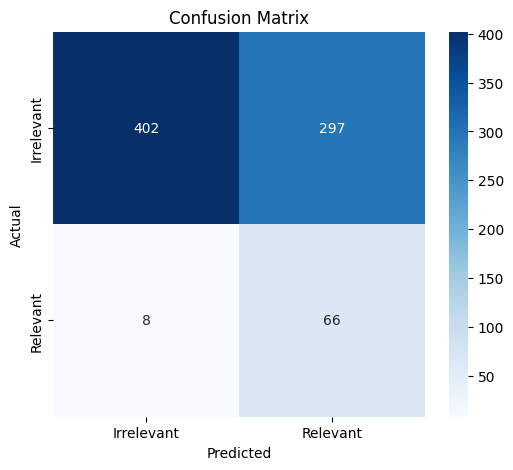

In [ ]:
print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test_true, y_test_pred_final)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Irrelevant', 'Relevant'], yticklabels=['Irrelevant', 'Relevant'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# zip and download
from google.colab import files
import shutil

OUTPUT_DIR = 'best_bert_model_max_precision'
best_model.save(OUTPUT_DIR)
print(f"\nBest model saved to directory: {OUTPUT_DIR}")

shutil.make_archive(OUTPUT_DIR, 'zip', OUTPUT_DIR)
print(f"Zipped model created: {OUTPUT_DIR}.zip. Starting download...")
files.download(f"{OUTPUT_DIR}.zip")